In [69]:
#IMPORT ALL RELEVANT LIBRARIES
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [70]:
from pandas import ExcelWriter
from pandas import ExcelFile

In [71]:
df = pd.read_excel('DubaiPopulationCommunity2.xlsx')
df.head(10)

,Community Code,Community,Total population
0,101,NAKHLAT DEIRA,2
1,111,CORNICHE,1735
2,112,RASS,7460
3,113,DHAGAYA,15899
4,114,BUTEEN,2841
5,115,SABKHA,3969
6,116,AYAL NASIR,19280
7,117,MURAR,38970
8,118,NAIF,50090
9,119,AL REGA,10480


### ADDING LATITUDE AND LONGITUDE USING GEOCODER

In [5]:
pip install geocoder

     |████████████████████████████████| 102kB 1.8MB/s ta 0:00:011
     |████████████████████████████████| 92kB 4.3MB/s eta 0:00:011
     |████████████████████████████████| 829kB 3.1MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


#### We will add Dubai to the Community/Neighborhood string so that geocoder is able to locate it and return co ordinates.

In [6]:
neighborhood=df.iloc[:,1]
neighborhood =neighborhood.astype(str) + ', DUBAI'
neighborhood.head()

0    NAKHLAT DEIRA, DUBAI
1         CORNICHE, DUBAI
2             RASS, DUBAI
3          DHAGAYA, DUBAI
4           BUTEEN, DUBAI
Name:  Community , dtype: object

In [7]:
df.iloc[:,1]=neighborhood

We merge different divisions of the same neighborhood into one and sum their populations.
For instance, Khawaneej One and Khawaneej Two are considered as Khawaneej. We will also sum the population of those respective communities and 
remove any duplicates.

In [9]:
newdf=df
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('FIRST', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('SECOND', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('THIRD', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('FOURTH', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('FIFTH', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('ONE', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('TWO', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('THREE', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('FOUR', '')
newdf.iloc[:,1] = newdf.iloc[:,1].str.replace('FIVE', '')
newdf.head(40)

,Community Code,Community,Total population
0,101,"NAKHLAT DEIRA, DUBAI",2
1,111,"CORNICHE, DUBAI",1735
2,112,"RASS, DUBAI",7460
3,113,"DHAGAYA, DUBAI",15899
4,114,"BUTEEN, DUBAI",2841
5,115,"SABKHA, DUBAI",3969
6,116,"AYAL NASIR, DUBAI",19280
7,117,"MURAR, DUBAI",38970
8,118,"NAIF, DUBAI",50090
9,119,"AL REGA, DUBAI",10480


We also observe that the population of some communities is very less like 2,14 etc. For this project, we will remove any 
communities with a population less than 500.

In [11]:
newdf = newdf[newdf['Total population'] > 500]

In [13]:
newdf.reset_index(drop=True, inplace=True)

In [14]:
sampledf=newdf

In [15]:
sampledf.head()

,Community Code,Community,Total population
0,111,"CORNICHE, DUBAI",1735
1,112,"RASS, DUBAI",7460
2,113,"DHAGAYA, DUBAI",15899
3,114,"BUTEEN, DUBAI",2841
4,115,"SABKHA, DUBAI",3969


Since we are considering the different divisions of a community as one, we will sum the population of those respective communities and 
remove any duplicates.

In [16]:
sum_df = sampledf.groupby([' Community ']).agg({'Total population': 'sum'})

In [17]:
sum_df.shape

(120, 1)

In [18]:
sum_df.head()

,Total population
Community,
"AWEER , DUBAI",9343
"AYAS, DUBAI",1757
"BADA, DUBAI",56734
"BAESHAA , DUBAI",15523
"BARAHA, DUBAI",24747


So we have 120 communities now after removing communities with very less population and combining the different community divisons.

In [19]:
sum_df=sum_df.reset_index()
sum_df.head()

,Community,Total population
0,"AWEER , DUBAI",9343
1,"AYAS, DUBAI",1757
2,"BADA, DUBAI",56734
3,"BAESHAA , DUBAI",15523
4,"BARAHA, DUBAI",24747


In [20]:
neighborhood_sum=sum_df.iloc[:,0]
neighborhood_sum=neighborhood_sum.astype(str) + ', DUBAI'

In [21]:
neighborhood_sum.shape

(120,)

#### Geocoder : Use geocoder to return co ordinates of all the communities/neighborhoods. We will assign a value of 1 to the latitude and longitude for cases where geocoder does not return any location

In [23]:
latitude3 = [1] * len(neighborhood_sum)
longitude3 =[1] * len(neighborhood_sum)
for i in range(len(neighborhood_sum)):
    address = neighborhood_sum[i]

    geolocator = Nominatim(user_agent="t_explorer")
    location = geolocator.geocode(address)
    if location !=None :
        latitude3[i] = location.latitude
        longitude3[i] = location.longitude

In [ ]:
dfcoordinates=pd.DataFrame([latitude3,longitude3])
dfcoordinates=dfcoordinates.T
sum_df['Latitude']=dfcoordinates[0]
sum_df['Longitude']=dfcoordinates[1]
sum_df.iloc[:,0]=neighborhood_sum

In [110]:
sum_df = sum_df[sum_df.Latitude != 1]
sum_df.shape

(66, 4)

In [118]:
sum_df.reset_index(drop=True, inplace=True)

In [119]:
sum_df.head()

,Community,Total population,Latitude,Longitude
0,"AWEER , DUBAI",9343,25.169420,55.541634
1,"AYAS, DUBAI",1757,25.229395,55.275679
2,"BADA, DUBAI",56734,2.947068,30.961800
3,"BARAHA, DUBAI",24747,25.281368,55.319413
4,"BARSHA SOUTH , DUBAI",61513,25.115422,55.208461


In [120]:
# We save this dataframe as csv so that we don't have to call geocoder each time.
sum_df.to_csv('DataDubaiNeighborhoodsCoordinates.csv')

In [36]:
## MAP NEIGHBORHOODS ON DUBAI
address = 'Dubai'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai are 25.0659637, 55.1713403.


In [114]:
# create map of Toronto using latitude and longitude values
map_dubai = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(sum_df['Latitude'], sum_df['Longitude'], sum_df[' Community ']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        tiles='Stamen Toner',
        parse_html=False).add_to(map_dubai)  
    
map_dubai

## FOURSQUARE DATA

In [72]:
df_dubai=pd.read_csv("DataDubaiNeighborhoodsCoordinates.csv")

In [73]:
df_dubai.head()

,Unnamed: 0,Community,Total population,Latitude,Longitude
0,0,"AWEER , DUBAI",9343,25.169420,55.541633
1,1,"AYAS, DUBAI",1757,25.229395,55.275679
2,2,"BADA, DUBAI",56734,2.947068,30.961799
3,3,"BARAHA, DUBAI",24747,25.281368,55.319413
4,4,"BARSHA SOUTH , DUBAI",61513,25.115422,55.208461


In [74]:
del df_dubai['Unnamed: 0']

In [75]:
# We will rename the Community column as Neighborhood for uniformity
df_dubai.rename(columns={' Community ':'Neighborhood'}, 
                 inplace=True)

In [76]:
df_dubai.head()

,Neighborhood,Total population,Latitude,Longitude
0,"AWEER , DUBAI",9343,25.169420,55.541633
1,"AYAS, DUBAI",1757,25.229395,55.275679
2,"BADA, DUBAI",56734,2.947068,30.961799
3,"BARAHA, DUBAI",24747,25.281368,55.319413
4,"BARSHA SOUTH , DUBAI",61513,25.115422,55.208461


In [8]:
## 2. USING FOURSQUARE DATA TO GET VENUE DETAILS

In [66]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [10]:
df_dubai.iloc[0,0]

' AWEER , DUBAI'

In [60]:
neighborhood_latitude = df_dubai.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_dubai.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_dubai.iloc[0, 0] # neighborhood names

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of  AWEER , DUBAI are 25.169420300000002, 55.541633499999996.


We will extract all the food venues around Aweer Dubai.

In [ ]:
# @hideen_cell
radius=5000
limit=100
foodid='4d4b7105d754a06374d81259'
categoryId=foodid
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&categoryId={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, categoryId, limit)

In [62]:
results = requests.get(url).json()

In [63]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [64]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Al Raslan Cafe,Café,25.178707,55.545097
1,Al Raslaan Star Cafe الرسلان ستار كافيه,Café,25.178739,55.545027
2,Zaffran AlAweer Cafe (مقهى زعفران العوير),Café,25.160281,55.535183
3,Sports Restaurant مطعم الرياضة,Burger Joint,25.175851,55.542336
4,Qalat al shay cafeteria (كافيتريا قلعة الشاي),Cafeteria,25.176925,55.542434


In [65]:
print('{} restaurant venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

11 restaurant venues were returned by Foursquare.


### Defining a function to repeat the above process for other neighborhoods

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            5000, 
            categoryId,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [84]:
#changes to column name ' Community ' to 'Neighborhood'
data_venues2 = getNearbyVenues(names=df_dubai['Neighborhood'],
                                   latitudes=df_dubai['Latitude'],
                                   longitudes=df_dubai['Longitude']
                                  )


 AWEER , DUBAI
 AYAS, DUBAI
 BADA, DUBAI
 BARAHA, DUBAI
 BARSHA SOUTH , DUBAI
 BARSHAA , DUBAI
 BUTEEN, DUBAI
 CORNICHE, DUBAI
 GARHOUD, DUBAI
 HAMRIYA, DUBAI
 HUDAIBA, DUBAI
 JADAF, DUBAI
 JAFLIYA, DUBAI
 KARAMA, DUBAI
 KHAWANEEJ , DUBAI
 MAMZER, DUBAI
 MANARA, DUBAI
 MANKHOOL, DUBAI
 MEZHAR , DUBAI
 MURAR, DUBAI
 MUTEENA, DUBAI
 NAHDA , DUBAI
 QUSAIS , DUBAI
 QUSAIS IND , DUBAI
 QUSAIS IND. , DUBAI
 RAFFA, DUBAI
 RASHIDIYA, DUBAI
 SABKHA, DUBAI
 SATWA, DUBAI
 TWAR , DUBAI
 WARQAA , DUBAI
 WARQAA  , DUBAI
 WASL, DUBAI
 YALAYIS 1, DUBAI
ABU HAIL, DUBAI
AL REGA, DUBAI
AYAL NASIR, DUBAI
BURJ KHALIFA, DUBAI
HATTA, DUBAI
HESSYAN , DUBAI
HOR AL ANZ, DUBAI
HOR AL ANZ EAST, DUBAI
JABAL ALI , DUBAI
JABAL ALI  , DUBAI
JABAL ALI INDUSTRIAL , DUBAI
JUMEIRA , DUBAI
LEHBAB , DUBAI
MARGHAM, DUBAI
ME'AISEM , DUBAI
MUHAISANAH , DUBAI
MUHAISANAH  , DUBAI
NAD SHAMMA, DUBAI
NAIF, DUBAI
NAKHLAT JUMEIRA , DUBAI
OUD METHA, DUBAI
PORT SAEED, DUBAI
SAIH SHUAIB 2, DUBAI
SAIH SHUAIB 3, DUBAI
SAIH SHUAIB 4, DUBA

In [85]:
print(data_venues2.shape)
data_venues2.head()

(5276, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"AWEER , DUBAI",25.16942,55.541633,Al Raslan Cafe,25.178707,55.545097,Café
1,"AWEER , DUBAI",25.16942,55.541633,Al Raslaan Star Cafe الرسلان ستار كافيه,25.178739,55.545027,Café
2,"AWEER , DUBAI",25.16942,55.541633,Zaffran AlAweer Cafe (مقهى زعفران العوير),25.160281,55.535183,Café
3,"AWEER , DUBAI",25.16942,55.541633,Sports Restaurant مطعم الرياضة,25.175851,55.542336,Burger Joint
4,"AWEER , DUBAI",25.16942,55.541633,Qalat al shay cafeteria (كافيتريا قلعة الشاي),25.176925,55.542434,Cafeteria


In [86]:
#Save the data on venues in a csv file to avoid running the entire script
data_venues2.to_csv('DubaiNeighborhoodVenueData5.csv')

In [8]:
df_venues=pd.read_csv("DubaiNeighborhoodVenueData5.csv")
del df_venues['Unnamed: 0']
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"AWEER , DUBAI",25.16942,55.541634,Al Raslan Cafe,25.178707,55.545097,Café
1,"AWEER , DUBAI",25.16942,55.541634,Al Raslaan Star Cafe الرسلان ستار كافيه,25.178739,55.545027,Café
2,"AWEER , DUBAI",25.16942,55.541634,Zaffran AlAweer Cafe (مقهى زعفران العوير),25.160281,55.535183,Café
3,"AWEER , DUBAI",25.16942,55.541634,Sports Restaurant مطعم الرياضة,25.175851,55.542336,Burger Joint
4,"AWEER , DUBAI",25.16942,55.541634,Qalat al shay cafeteria (كافيتريا قلعة الشاي),25.176925,55.542434,Cafeteria


In [9]:
data_venues2=df_venues.iloc[:,[0,6]]

In [10]:
#Lets check how many venues are found for each neighborhood
x1=data_venues2.groupby('Neighborhood').count()

Most neighborhoods have the maximum number of food venues, i.e. 100. Lets find out how many unique categories of restaurants are in these neighborhoods of Dubai.

In [11]:
print('There are {} unique categories of restaurants.'.format(len(data_venues2['Venue Category'].unique())))

There are 97 unique categories of restaurants.


In [12]:
data_venues2['Venue Category'].unique()

array(['Café', 'Burger Joint', 'Cafeteria', 'Indian Restaurant',
       'Seafood Restaurant', 'Fast Food Restaurant', 'Steakhouse',
       'Greek Restaurant', 'French Restaurant', 'Pakistani Restaurant',
       'Vegetarian / Vegan Restaurant', 'Restaurant',
       'Mexican Restaurant', 'Brazilian Restaurant',
       'Japanese Restaurant', 'Italian Restaurant',
       'Middle Eastern Restaurant', 'Comfort Food Restaurant',
       'Korean Restaurant', 'Gluten-free Restaurant',
       'Turkish Restaurant', 'Thai Restaurant', 'Diner',
       'Mediterranean Restaurant', 'Breakfast Spot',
       'Portuguese Restaurant', 'American Restaurant', 'Asian Restaurant',
       'Bakery', 'Snack Place', 'Filipino Restaurant',
       'African Restaurant', 'Chinese Restaurant', 'Donut Shop',
       'Persian Restaurant', 'Fried Chicken Joint', 'Lebanese Restaurant',
       'Iraqi Restaurant', 'Syrian Restaurant', 'Kurdish Restaurant',
       'Dim Sum Restaurant', 'BBQ Joint', 'Pizza Place', 'Sandwich Pla

###  Comparing the frequency of the different categories of restaurants across all neighborhoods. 

We will first find the average frequency of each category of restaurant for each neighborhood. Then we will visualize the results.

In [13]:
# one hot encoding
dubai_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dubai_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dubai_onehot.columns[-1]] + list(dubai_onehot.columns[:-1])
dubai_onehot = dubai_onehot[fixed_columns]

dubai_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Bosnian Restaurant,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Pastelaria,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shawarma Place,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,"AWEER , DUBAI",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"AWEER , DUBAI",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"AWEER , DUBAI",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"AWEER , DUBAI",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"AWEER , DUBAI",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
dubai_onehot.shape

(5276, 98)

We will group the above dataframe in two ways: 1)Frequency of each category per neighborhood 2) mean of the frequency of occurrence
    of each category

In [15]:
#Frequency of each category per neighborhood
dubai_grouped_freq = dubai_onehot.groupby('Neighborhood').sum().reset_index()
dubai_grouped_freq.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Bosnian Restaurant,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Pastelaria,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shawarma Place,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,"AWEER , DUBAI",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"AYAS, DUBAI",0,1,2,0,1,0,0,0,3,0,0,0,1,4,0,9,0,0,12,0,0,2,0,1,0,0,1,1,0,0,0,0,3,1,0,0,0,0,6,1,0,0,1,3,0,0,0,2,0,0,0,4,4,1,0,0,1,1,1,5,0,0,0,0,0,1,0,1,0,0,0,1,11,0,0,0,0,2,0,1,0,0,0,0,4,0,0,0,0,0,1,0,4,2,0,0,0
2,"BARAHA, DUBAI",0,2,2,0,6,0,1,0,2,0,0,0,0,2,1,2,0,0,7,0,0,2,0,0,0,1,0,1,0,0,0,0,5,1,0,0,0,0,2,3,0,0,0,1,0,0,0,8,0,2,1,0,3,1,1,0,1,1,0,13,0,0,0,0,3,0,0,2,0,1,0,0,7,0,0,2,0,4,0,0,0,0,0,1,0,1,1,0,0,1,2,0,1,0,0,0,2
3,"BARSHA SOUTH , DUBAI",1,2,2,0,1,1,1,1,5,1,1,0,1,3,0,3,0,0,19,0,0,2,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,0,3,0,0,0,0,2,0,0,0,3,0,2,6,0,0,0,0,0,1,0,0,1,0,1,0,9,1,0,2,0,4,0,0,1,0,0,0,2,2,0,0,1,0,2,2,3,0,0,0,0
4,"BARSHAA , DUBAI",1,3,1,0,3,1,1,0,4,2,1,0,1,2,0,1,0,0,17,0,0,2,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,3,0,2,0,0,1,0,0,0,2,0,0,1,4,1,0,0,0,3,1,1,4,0,0,0,0,0,1,0,0,0,1,0,0,11,1,0,3,0,5,0,0,0,0,0,1,2,1,0,0,1,0,3,1,1,0,0,0,0


In [16]:
#Mean Frequency of each category per neighborhood
dubai_grouped_meanfreq = dubai_onehot.groupby('Neighborhood').mean().reset_index()
dubai_grouped_meanfreq.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Bosnian Restaurant,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Pastelaria,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shawarma Place,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant
0,"AWEER , DUBAI",0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.090909,0.0,0.181818,0.454545,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.090909,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.090909,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.090909,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00
1,"AYAS, DUBAI",0.00,0.01,0.02,0.0,0.01,0.00,0.00,0.00,0.03,0.00,0.00,0.0,0.01,0.04,0.00,0.090000,0.0,0.000000,0.120000,0.0,0.0,0.02,0.0,0.01,0.00,0.00,0.01,0.01,0.0,0.00,0.00,0.00,0.030000,0.01,0.0,0.0,0.0,0.0,0.06,0.01,0.00,0.0,0.01,0.03,0.0,0.0,0.0,0.020000,0.0,0.00,0.00,0.04,0.04,0.01,0.00,0.0,0.01,0.01,0.01,0.05,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.00,0.00,0.00,0.01,0.11,0.00,0.0,0.00,0.0,0.020000,0.0,0.01,0.00,0.0,0.0,0.00,0.04,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.04,0.02,0.0,0.0,0.00
2,"BARAHA, DUBAI",0.00,0.02,0.02,0.0,0.06,0.00,0.01,0.00,0.02,0.00,0.00,0.0,0.00,0.02,0.01,0.020000,0.0,0.000000,0.070000,0.0,0.0,0.02,0.0,0.00,0.00,0.01,0.00,0.01,0.0,0.00,0.00,0.00,0.050000,0.01,0.0,0.0,0.0,0.0,0.02,0.03,0.00,0.0,0.00,0.01,0.0,0.0,0.0,0.080000,0.0,0.02,0.01,0.00,0.03,0.01,0.01,0.0,0.01,0.01,0.00,0.13,0.0,0.0,0.0,0.0,0.03,0.00,0.0,0.02,0.00,0.01,0.00,0.00,0.07,0.00,0.0,0.02,0.0,0.040000,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.01,0.01,0.0,0.00,0.01,0.02,0.00,0.01,0.00,0.0,0.0,0.02
3,"BARSHA SOUTH , DUBAI",0.01,0.02,0.02,0.0,0.01,0.01,0.01,0.01,0.05,0.01,0.01,0.0,0.01,0.03,0.00,0.030000,0.0,0.000000,0.190000,0.0,0.0,0.02,0.0,0.00,0.00,0.00,0.01,0.01,0.0,0.01,0.01,0.00,0.010000,0.00,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.00,0.02,0.0,0.0,0.0,0.030000,0.0,0.00,0.00,0.00,0.02,0.00,0.00,0.0,0.03,0.00,0.02,0.06,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.01,0.00,0.01,0.00,0.09,0.01,0.0,0.02,0.0,0.040000,0.0,0.00,0.01,0.0,0.0,0.00,0.02,0.02,0.00,0.0,0.01,0.00,0.02,0.02,0.03,0.00,0.0,0.0,0.00
4,"BARSHAA , DUBAI",0.01,0.03,0.01,0.0,0.03,0.01,0.01,0.00,0.04,0.02,0.01,0.0,0.01,0.02,0.00,0.010000,0.0,0.000000,0.170000,0.0,0.0,0.02,0.0,0.00,0.01,0.00,0.00,0.01,0.0,0.01,0.00,0.01,0.010000,0.00,0.0,0.0,0.0,0.0,0.03,0.00,0.02,0.0,0.00,0.01,0.0,0.0,0.0,0.020000,0.0,0.00,0.01,0.04,

Now we will compare the frequency of these categories including all neighborhoods.

In [19]:
freqall=dubai_grouped_freq.sum(axis=0)
freqall=pd.DataFrame(freqall)
freqall.columns=['Frequency']
freqall.head()

,Frequency
Neighborhood,"AWEER , DUBAI AYAS, DUBAI BARAHA, DUBAI BARSH..."
Afghan Restaurant,10
African Restaurant,45
American Restaurant,105
Arepa Restaurant,1


In [20]:
#Remove the first row
freqall = freqall.iloc[1:]

In [21]:
freqall.head()

,Frequency
Afghan Restaurant,10
African Restaurant,45
American Restaurant,105
Arepa Restaurant,1
Asian Restaurant,189


### Sorting categories to find the most frequent categories of restaurants in Dubai

In [22]:
#Sorting categories to find the most frequent categories of restaurants
freqall.sort_values(by='Frequency', ascending=False, inplace=True)
freqall.head(20)

,Frequency
Café,611
Middle Eastern Restaurant,493
Restaurant,390
Indian Restaurant,303
Fast Food Restaurant,278
Bakery,198
Asian Restaurant,189
Italian Restaurant,174
Burger Joint,170
Seafood Restaurant,161


We can see the top most common restaurant categories in the neighborhoods of Dubai are Cafes, Middle eastern restaurants, Indian and fast food  (considering burger joints as fast food as well). Lets plot a bar graph with the frequency of these categories.

In [23]:
#Import Matplotlib
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


In [24]:
freqall.sort_values(by='Frequency', ascending=False, inplace=True)

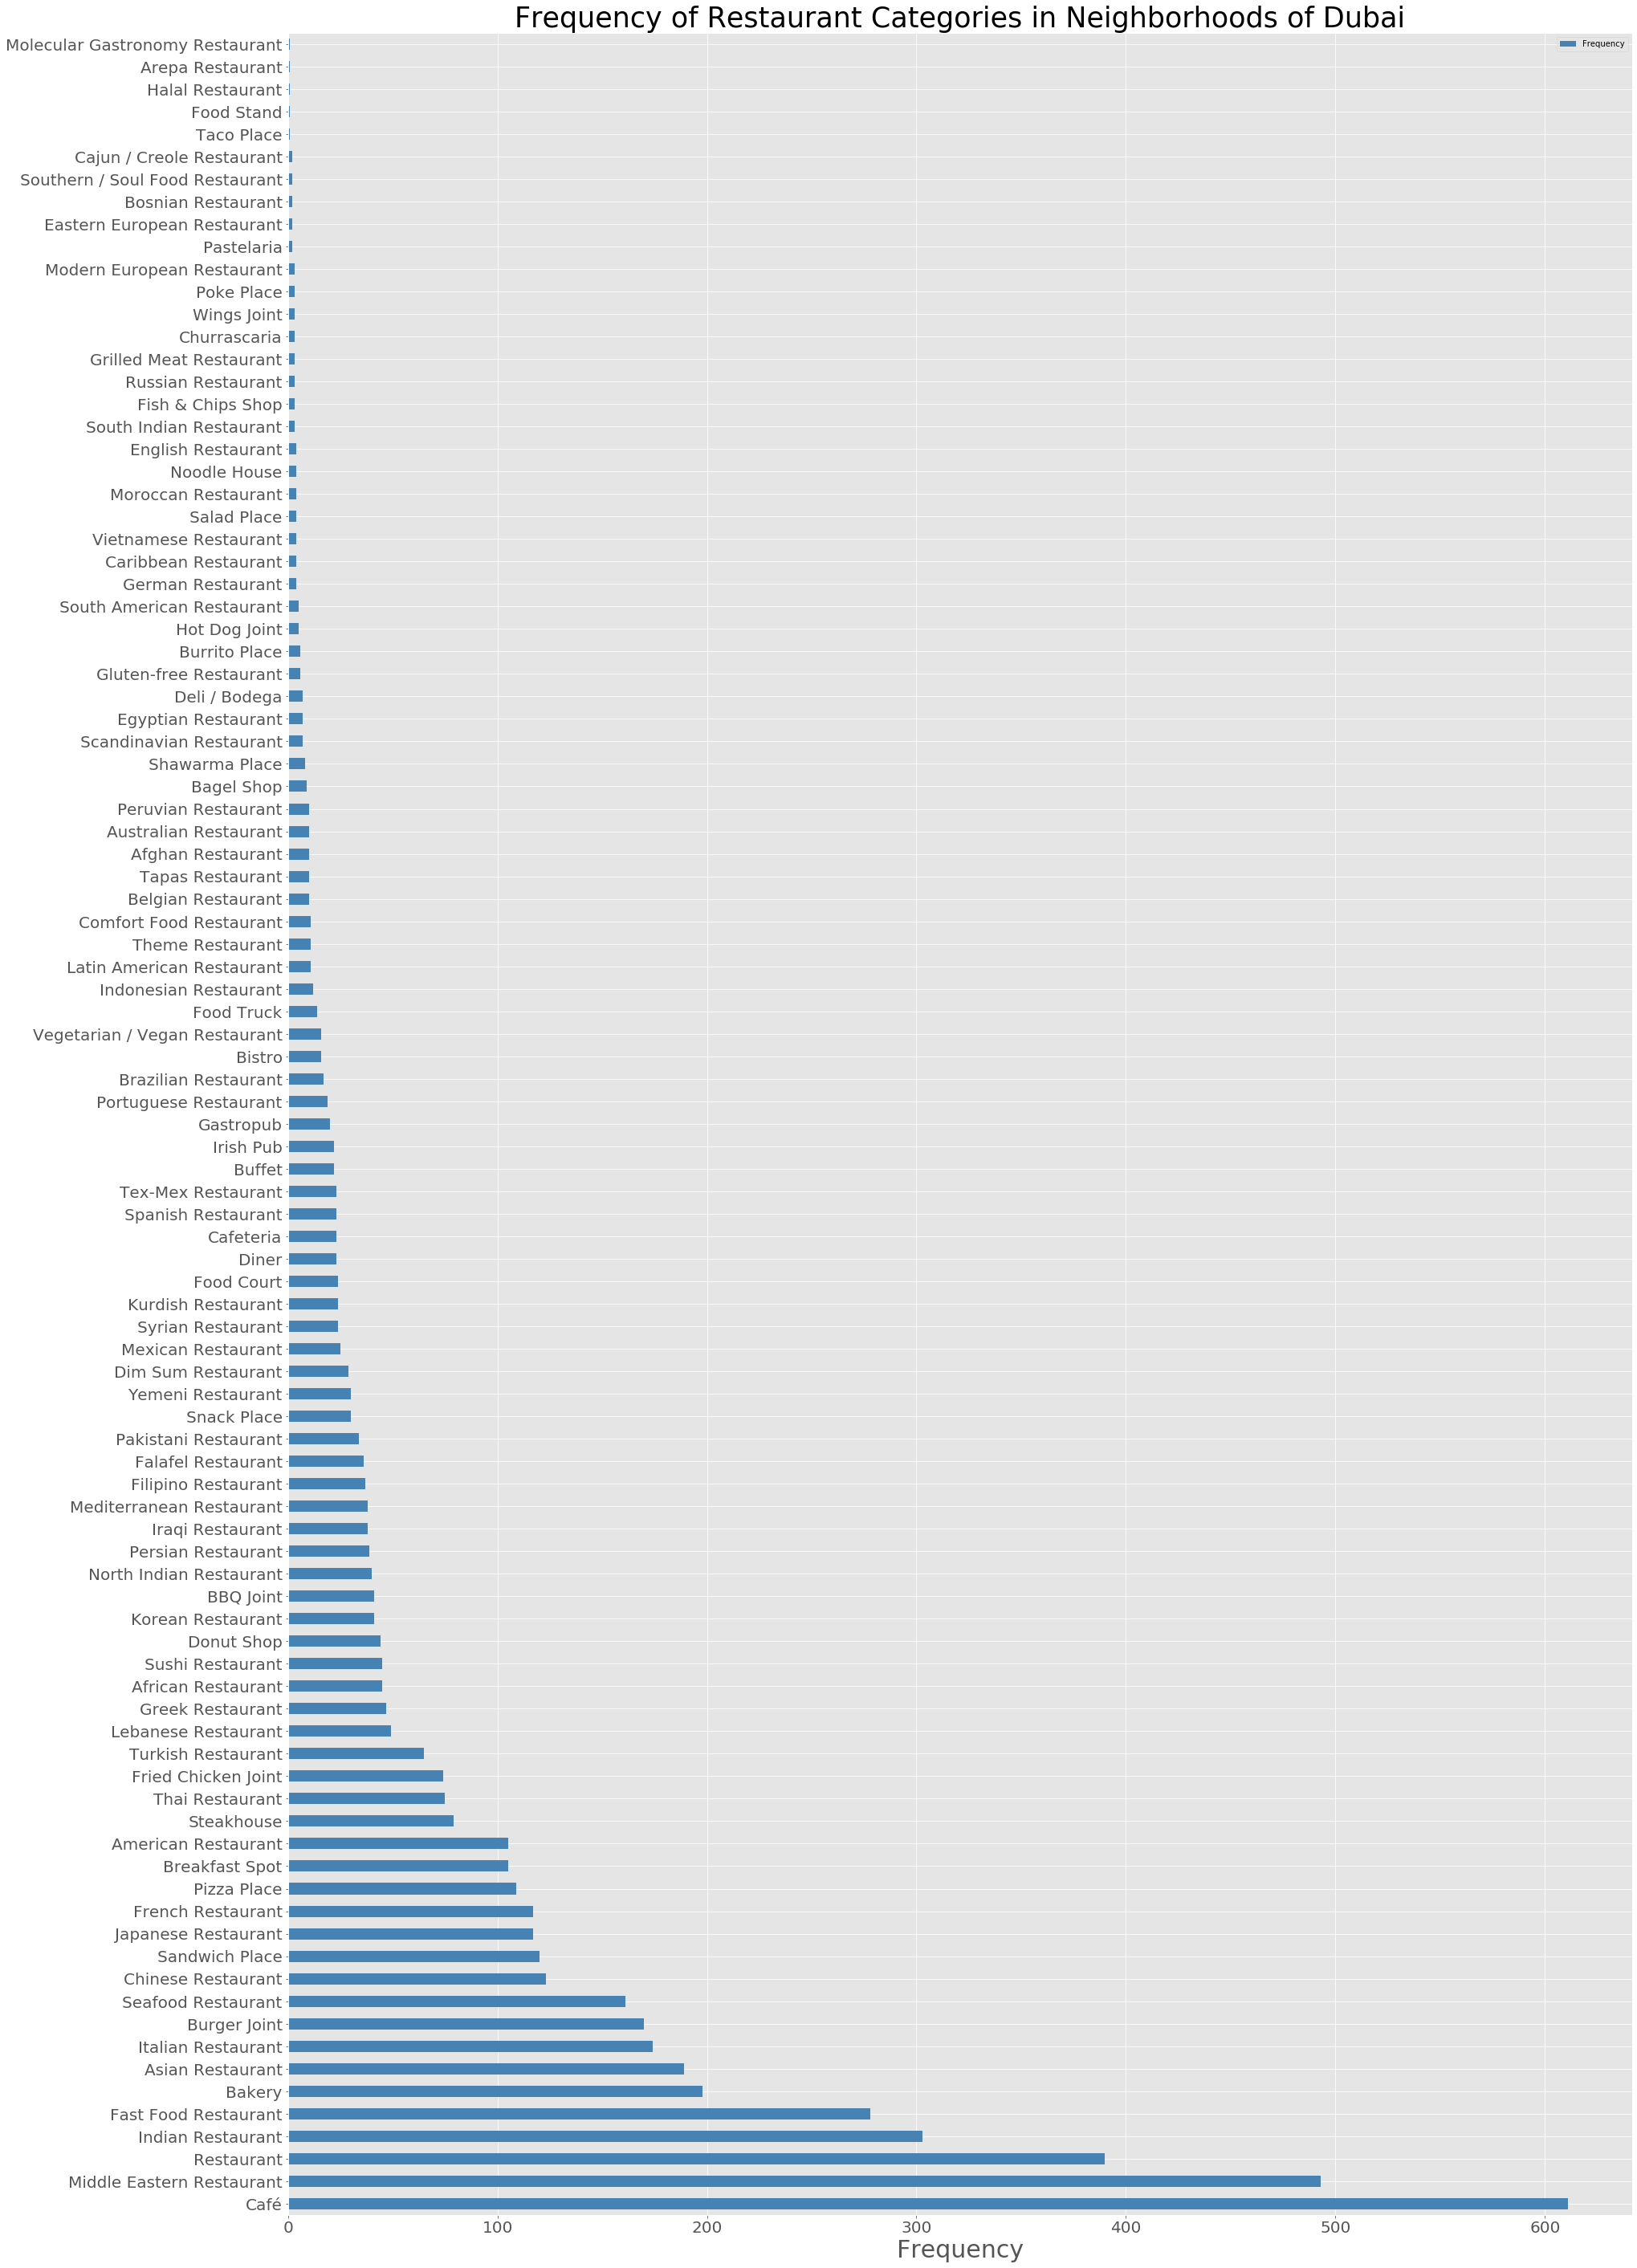

In [24]:
freqall.plot(kind='barh', figsize=(30, 50), color='steelblue')
plt.xlabel('Frequency', fontsize=30)
plt.title('Frequency of Restaurant Categories in Neighborhoods of Dubai', fontsize=35)
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 
plt.savefig('freq2.png')

### K-means clustering - Now lets analyse whether certain cuisines or categories are neighborhood specific or not. We will explore this using k means clustering analyses to find whether some neighborhoods are similar to each other in terms of food venues.

In [25]:
# Function to find most common venues in neighborhoods
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
# create a dataframe with the neighborhood and their respective common venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dubai_grouped_meanfreq['Neighborhood']

for ind in np.arange(dubai_grouped_meanfreq.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dubai_grouped_meanfreq.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"AWEER , DUBAI",Café,Cafeteria,Indian Restaurant,Seafood Restaurant,Burger Joint,Fast Food Restaurant,Yemeni Restaurant,Filipino Restaurant,Donut Shop,Eastern European Restaurant
1,"AYAS, DUBAI",Café,Restaurant,Burger Joint,French Restaurant,Middle Eastern Restaurant,Italian Restaurant,Breakfast Spot,Steakhouse,Japanese Restaurant,Turkish Restaurant
2,"BARAHA, DUBAI",Middle Eastern Restaurant,Indian Restaurant,Café,Restaurant,Asian Restaurant,Fast Food Restaurant,Seafood Restaurant,Japanese Restaurant,Fried Chicken Joint,North Indian Restaurant
3,"BARSHA SOUTH , DUBAI",Café,Restaurant,Middle Eastern Restaurant,Bakery,Seafood Restaurant,Burger Joint,Lebanese Restaurant,Breakfast Spot,Indian Restaurant,Turkish Restaurant
4,"BARSHAA , DUBAI",Café,Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Italian Restaurant,Bakery,African Restaurant,Thai Restaurant,French Restaurant,Asian Restaurant


### K mean Clustering on the data

In [27]:
# set number of clusters
kclusters = 5

dubai_grouped_clustering = dubai_grouped_meanfreq.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dubai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 2, 1, 1, 2, 1, 2, 2, 1], dtype=int32)

In [28]:
#dubai_grouped_clustering

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_
dubai_merged = df_dubai

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dubai_merged = dubai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dubai_merged.head() # check the last columns!

,Neighborhood,Total population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"AWEER , DUBAI",9343,25.169420,55.541633,4.0,Café,Cafeteria,Indian Restaurant,Seafood Restaurant,Burger Joint,Fast Food Restaurant,Yemeni Restaurant,Filipino Restaurant,Donut Shop,Eastern European Restaurant
1,"AYAS, DUBAI",1757,25.229395,55.275679,1.0,Café,Restaurant,Burger Joint,French Restaurant,Middle Eastern Restaurant,Italian Restaurant,Breakfast Spot,Steakhouse,Japanese Restaurant,Turkish Restaurant
2,"BADA, DUBAI",56734,2.947068,30.961799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"BARAHA, DUBAI",24747,25.281368,55.319413,2.0,Middle Eastern Restaurant,Indian Restaurant,Café,Restaurant,Asian Restaurant,Fast Food Restaurant,Seafood Restaurant,Japanese Restaurant,Fried Chicken Joint,North Indian Restaurant
4,"BARSHA SOUTH , DUBAI",61513,25.115422,55.208461,1.0,Café,Restaurant,Middle Eastern Restaurant,Bakery,Seafood Restaurant,Burger Joint,Lebanese Restaurant,Breakfast Spot,Indian Restaurant,Turkish Restaurant


In [30]:
#Remove Nans
dubai_merged.dropna(inplace=True)
#dubai_merged.reset_index()

In [32]:
dubai_merged.dtypes

Neighborhood               object
Total population            int64
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [33]:
#Convert cluster labels to integer
dubai_merged['Cluster Labels'] = dubai_merged['Cluster Labels'].astype(int)

In [34]:
## MAP CLUSTERS ON DUBAI
address = 'Dubai'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dubai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dubai are 25.0750095, 55.18876088183319.


In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dubai_merged['Latitude'], dubai_merged['Longitude'], dubai_merged['Neighborhood'], dubai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('cluster2.html')
map_clusters


### Interestingly, the neighborhoods are clustered in a way that suggests that restaurant categories are highly homogenous in neighborhoods with geographical proximity. The first cluster (cluster 0 in map) includes just two places and is on the outskirts. The second cluster (Cluster 1 in map) is a huge cluster spread around the whole city. While cluster 3 seems to be in a closely knit center of Dubai. Cluster 4 is towrads the border of the other cities and cluster 5 is scattered on places far from central Dubai. We may also extrapolate these clusters to clustering of taste and preferences of people living in these neihgborhoods and the environment.

In [ ]:
cluster1=dubai_merged.loc[dubai_merged['Cluster Labels'] == 0, :]

In [36]:
cluster2=dubai_merged.loc[dubai_merged['Cluster Labels'] == 1, :]
cluster2

,Neighborhood,Total population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"AYAS, DUBAI",1757,25.229395,55.275679,1,Café,Restaurant,Burger Joint,French Restaurant,Middle Eastern Restaurant,Italian Restaurant,Breakfast Spot,Steakhouse,Japanese Restaurant,Turkish Restaurant
4,"BARSHA SOUTH , DUBAI",61513,25.115422,55.208461,1,Café,Restaurant,Middle Eastern Restaurant,Bakery,Seafood Restaurant,Burger Joint,Lebanese Restaurant,Breakfast Spot,Indian Restaurant,Turkish Restaurant
5,"BARSHAA , DUBAI",54052,25.089549,55.194570,1,Café,Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Italian Restaurant,Bakery,African Restaurant,Thai Restaurant,French Restaurant,Asian Restaurant
7,"CORNICHE, DUBAI",1735,25.062021,55.166513,1,Café,Restaurant,Breakfast Spot,Italian Restaurant,Indian Restaurant,Asian Restaurant,French Restaurant,Pizza Place,Gastropub,Burger Joint
10,"HUDAIBA, DUBAI",14191,25.240050,55.277459,1,Café,Restaurant,Burger Joint,Middle Eastern Restaurant,French Restaurant,Turkish Restaurant,Bakery,Italian Restaurant,Steakhouse,Breakfast Spot
11,"JADAF, DUBAI",5104,25.218141,55.328888,1,Café,Indian Restaurant,French Restaurant,Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Japanese Restaurant,Bakery,Italian Restaurant,Steakhouse
12,"JAFLIYA, DUBAI",23963,25.216548,55.264507,1,Café,Restaurant,Burger Joint,French Restaurant,Japanese Restaurant,Bakery,Steakhouse,Middle Eastern Restaurant,Turkish Restaurant,American Restaurant
16,"MANARA, DUBAI",8271,25.170002,55.215893,1,Café,Middle Eastern Restaurant,Restaurant,Burger Joint,Turkish Restaurant,Bakery,Indian Restaurant,Peruvian Restaurant,Italian Restaurant,Japanese Restaurant
18,"MEZHAR , DUBAI",27869,25.261248,55.441177,1,Café,Bakery,Fast Food Restaurant,Burger Joint,Middle Eastern Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,Food Truck,Restaurant
26,"RASHIDIYA, DUBAI",37167,25.230259,55.391066,1,Café,Middle Eastern Restaurant,Bakery,Indian Restaurant,Seafood Restaurant,Burger Joint,Fast Food Restaurant,Pizza Place,Steakhouse,Restaurant


In [37]:
cluster3=dubai_merged.loc[dubai_merged['Cluster Labels'] == 2, :]
cluster3

,Neighborhood,Total population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"BARAHA, DUBAI",24747,25.281368,55.319413,2,Middle Eastern Restaurant,Indian Restaurant,Café,Restaurant,Asian Restaurant,Fast Food Restaurant,Seafood Restaurant,Japanese Restaurant,Fried Chicken Joint,North Indian Restaurant
6,"BUTEEN, DUBAI",2841,25.263057,55.320584,2,Middle Eastern Restaurant,Café,Indian Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Fast Food Restaurant,North Indian Restaurant,Seafood Restaurant,Bakery
8,"GARHOUD, DUBAI",18535,25.239696,55.358443,2,Middle Eastern Restaurant,Café,Fast Food Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,American Restaurant,Asian Restaurant,Thai Restaurant,Snack Place
9,"HAMRIYA, DUBAI",36738,25.287657,55.323997,2,Middle Eastern Restaurant,Café,Indian Restaurant,Fast Food Restaurant,Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,Fried Chicken Joint,French Restaurant
13,"KARAMA, DUBAI",75066,25.248230,55.305157,2,Indian Restaurant,Café,Middle Eastern Restaurant,Restaurant,Asian Restaurant,French Restaurant,Japanese Restaurant,Korean Restaurant,Chinese Restaurant,Seafood Restaurant
15,"MAMZER, DUBAI",14938,25.312857,55.340863,2,Middle Eastern Restaurant,Fast Food Restaurant,Bakery,Café,Italian Restaurant,Seafood Restaurant,Falafel Restaurant,American Restaurant,Cafeteria,Indian Restaurant
17,"MANKHOOL, DUBAI",40091,25.250827,55.295620,2,Indian Restaurant,Café,Restaurant,Middle Eastern Restaurant,Asian Restaurant,French Restaurant,Japanese Restaurant,Greek Restaurant,Fast Food Restaurant,Chinese Restaurant
19,"MURAR, DUBAI",38970,25.276677,55.309763,2,Indian Restaurant,Middle Eastern Restaurant,Restaurant,Café,Asian Restaurant,Seafood Restaurant,Fast Food Restaurant,North Indian Restaurant,Fried Chicken Joint,American Restaurant
20,"MUTEENA, DUBAI",46185,25.273892,55.322630,2,Middle Eastern Restaurant,Indian Restaurant,Restaurant,Café,Asian Restaurant,Fast Food Restaurant,Japanese Restaurant,Seafood Restaurant,Sandwich Place,Fried Chicken Joint
21,"NAHDA , DUBAI",93385,25.288351,55.363138,2,Middle Eastern Restaurant,Fast Food Restaurant,Bakery,Restaurant,Café,Asian Restaurant,Italian Restaurant,American Restaurant,Falafel Restaurant,Indian Restaurant


In [38]:
cluster4=dubai_merged.loc[dubai_merged['Cluster Labels'] == 3, :]
cluster4

,Neighborhood,Total population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"KHAWANEEJ , DUBAI",17416,25.222142,55.531052,3,Cafeteria,Restaurant,Café,Burger Joint,Bakery,Comfort Food Restaurant,Poke Place,Fried Chicken Joint,French Restaurant,Grilled Meat Restaurant
39,"HESSYAN , DUBAI",3492,24.942216,54.970888,3,Food Truck,Italian Restaurant,Café,Fast Food Restaurant,Restaurant,Burger Joint,Fried Chicken Joint,Indian Restaurant,Pizza Place,Cafeteria
44,"JABAL ALI INDUSTRIAL , DUBAI",154437,24.984883,55.108618,3,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Burger Joint,Deli / Bodega,Pizza Place,Middle Eastern Restaurant,Restaurant,Café,Food Court
56,"SAIH SHUAIB 2, DUBAI",14491,24.912801,55.014553,3,Fast Food Restaurant,Restaurant,Pizza Place,Middle Eastern Restaurant,Indian Restaurant,Café,Italian Restaurant,Chinese Restaurant,Burger Joint,Comfort Food Restaurant
57,"SAIH SHUAIB 3, DUBAI",11144,24.907429,55.029484,3,Café,Fast Food Restaurant,Restaurant,Italian Restaurant,Indian Restaurant,Pizza Place,Chinese Restaurant,Middle Eastern Restaurant,Sandwich Place,Cafeteria
58,"SAIH SHUAIB 4, DUBAI",11170,24.912801,55.014553,3,Fast Food Restaurant,Restaurant,Pizza Place,Middle Eastern Restaurant,Indian Restaurant,Café,Italian Restaurant,Chinese Restaurant,Burger Joint,Comfort Food Restaurant
61,"WADI AL SAFA 5, DUBAI",21241,25.075686,55.351945,3,Café,Fast Food Restaurant,Restaurant,Italian Restaurant,Pizza Place,Cafeteria,Asian Restaurant,Sandwich Place,Turkish Restaurant,Thai Restaurant


In [39]:
cluster5=dubai_merged.loc[dubai_merged['Cluster Labels'] == 4, :]
cluster5

,Neighborhood,Total population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"AWEER , DUBAI",9343,25.169420,55.541633,4,Café,Cafeteria,Indian Restaurant,Seafood Restaurant,Burger Joint,Fast Food Restaurant,Yemeni Restaurant,Filipino Restaurant,Donut Shop,Eastern European Restaurant
30,"WARQAA , DUBAI",39407,25.191657,55.419019,4,Café,Middle Eastern Restaurant,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Burger Joint,Bakery,Indian Restaurant,Italian Restaurant
31,"WARQAA , DUBAI",24141,25.191657,55.419019,4,Café,Middle Eastern Restaurant,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Burger Joint,Bakery,Indian Restaurant,Italian Restaurant
38,"HATTA, DUBAI",14045,24.799096,56.114941,4,Café,Restaurant,Fried Chicken Joint,Cafeteria,Burger Joint,Middle Eastern Restaurant,Fast Food Restaurant,Filipino Restaurant,Diner,Donut Shop
63,"WARSAN , DUBAI",130213,25.160381,55.425285,4,Café,Middle Eastern Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Indian Restaurant,Burger Joint,Asian Restaurant,Sandwich Place


Lets analyse the above clusters in terms of frequency of the top venues. We will merge the cluster data with the top 10 venues with the numerical data in the dataframe dubai_grouped_freq.

### Cluster 1 (cluster 0 from above)

In [40]:
freq_analysis_clusters=dubai_grouped_freq
sum_column = freq_analysis_clusters.iloc[:,1:98].sum(axis=1)
freq_analysis_clusters['Total Restaurants']=sum_column #TOTAL RESTAURANTS IN EACH NEIGHBORHOOD
freq_analysis_clusters.head(10)

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Bosnian Restaurant,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Pastelaria,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shawarma Place,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant,Total Restaurants
0,"AWEER , DUBAI",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11
1,"AYAS, DUBAI",0,1,2,0,1,0,0,0,3,0,0,0,1,4,0,9,0,0,12,0,0,2,0,1,0,0,1,1,0,0,0,0,3,1,0,0,0,0,6,1,0,0,1,3,0,0,0,2,0,0,0,4,4,1,0,0,1,1,1,5,0,0,0,0,0,1,0,1,0,0,0,1,11,0,0,0,0,2,0,1,0,0,0,0,4,0,0,0,0,0,1,0,4,2,0,0,0,100
2,"BARAHA, DUBAI",0,2,2,0,6,0,1,0,2,0,0,0,0,2,1,2,0,0,7,0,0,2,0,0,0,1,0,1,0,0,0,0,5,1,0,0,0,0,2,3,0,0,0,1,0,0,0,8,0,2,1,0,3,1,1,0,1,1,0,13,0,0,0,0,3,0,0,2,0,1,0,0,7,0,0,2,0,4,0,0,0,0,0,1,0,1,1,0,0,1,2,0,1,0,0,0,2,100
3,"BARSHA SOUTH , DUBAI",1,2,2,0,1,1,1,1,5,1,1,0,1,3,0,3,0,0,19,0,0,2,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,0,3,0,0,0,0,2,0,0,0,3,0,2,6,0,0,0,0,0,1,0,0,1,0,1,0,9,1,0,2,0,4,0,0,1,0,0,0,2,2,0,0,1,0,2,2,3,0,0,0,0,100
4,"BARSHAA , DUBAI",1,3,1,0,3,1,1,0,4,2,1,0,1,2,0,1,0,0,17,0,0,2,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,3,0,2,0,0,1,0,0,0,2,0,0,1,4,1,0,0,0,3,1,1,4,0,0,0,0,0,1,0,0,0,1,0,0,11,1,0,3,0,5,0,0,0,0,0,1,2,1,0,0,1,0,3,1,1,0,0,0,0,100
5,"BUTEEN, DUBAI",0,2,2,0,6,0,1,0,3,0,0,0,0,2,1,0,0,0,9,0,0,2,0,0,0,2,0,1,0,0,0,0,4,1,0,0,0,0,2,3,0,0,0,0,0,0,0,8,0,2,1,0,4,2,1,0,1,0,0,10,0,0,0,0,3,0,0,2,0,1,0,0,7,0,0,2,0,3,0,1,0,0,0,1,0,1,2,0,1,1,2,0,1,1,0,0,1,100
6,"CORNICHE, DUBAI",0,1,2,0,5,1,0,0,1,1,1,0,0,8,0,3,0,0,12,1,1,2,1,0,1,0,0,0,1,0,0,2,0,0,0,0,0,1,4,0,3,0,0,1,1,0,1,5,1,0,1,7,0,1,0,2,1,1,0,2,0,0,0,1,0,0,0,0,0,3,0,0,9,0,0,1,0,2,0,0,0,0,0,0,1,2,0,0,0,0,2,1,1,0,1,0,0,100
7,"GARHOUD, DUBAI",0,2,3,0,3,0,0,0,0,0,0,0,0,1,1,1,0,2,13,0,0,2,0,0,0,0,1,1,0,0,0,0,7,0,0,0,0,0,1,2,0,0,0,0,0,0,0,2,0,1,1,0,1,0,1,0,1,1,1,16,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,4,1,4,0,2,0,0,0,2,0,2,2,0,0,1,3,0,0,0,0,0,2,93
8,"HAMRIYA, DUBAI",0,1,2,0,5,0,1,0,2,0,0,0,0,1,1,2,0,0,8,0,0,2,0,0,0,1,0,1,0,0,0,0,7,1,0,0,0,0,2,3,0,0,0,1,0,0,0,8,0,2,0,0,4,1,1,0,0,1,0,14,0,0,0,0,2,1,0,2,0,1,0,0,7,0,0,2,0,4,0,0,0,0,0,1,0,1,1,0,0,1,2,0,1,0,0,0,2,100
9,"HUDAIBA, DUBAI",0,1,2,0,1,0,0,0,4,0,0,0,1,3,0,8,0,0,12,0,0,2,0,1,0,1,1,1,0,0,0,0,3,1,0,0,0,0,5,0,0,0,1,3,0,0,0,3,0,0,0,4,3,2,0,0,0,1,1,6,0,0,0,0,0,1,0,2,0,0,0,1,10,0,0,1,0,2,0,1,0,0,0,0,3,1,0,0,0,0,1,0,5,1,0,0,0,100


In [ ]:
#FROM THE ABOVE DATASET WE WILL BE EXTRACTING CLUSTER 1 RESTAURANT CATEGORY DETAILS
freq_analysis_cluster1=freq_analysis_clusters.merge(cluster1, on='Neighborhood', how='inner')

In [42]:
freq_sum_cluster1=freq_analysis_cluster1.iloc[:,1:98].sum(axis=0) # TOTAL RESTAURANTS OF EACH CATEOGORY CLUSTER 1
freq_percent_cluster1=(freq_sum_cluster1/freq_sum_cluster1.sum())*100 # this contains the percentage of each category in this cluster
Total_Res_cluster1=freq_sum_cluster1.sum() # total number of restaurants in Cluster1
freq_percent_cluster1.head(20) #This is the percentage of restaurant categories in cluster 1

Afghan Restaurant             0.000000
African Restaurant            0.000000
American Restaurant           0.000000
Arepa Restaurant              0.000000
Asian Restaurant              0.000000
Australian Restaurant         0.000000
BBQ Joint                     0.000000
Bagel Shop                    0.000000
Bakery                        0.000000
Belgian Restaurant            0.000000
Bistro                        0.000000
Bosnian Restaurant            0.000000
Brazilian Restaurant          0.000000
Breakfast Spot                0.000000
Buffet                        0.000000
Burger Joint                  0.000000
Burrito Place                 0.000000
Cafeteria                     0.000000
Café                         18.181818
Cajun / Creole Restaurant     0.000000
dtype: float64

In [43]:
#REPEATING THE ABVOE WITH ALL OTHER CLUSTERS
freq_analysis_cluster2=freq_analysis_clusters.merge(cluster2, on='Neighborhood', how='inner')
freq_sum_cluster2=freq_analysis_cluster2.iloc[:,1:98].sum(axis=0)
freq_percent_cluster2=(freq_sum_cluster2/freq_sum_cluster2.sum())*100
Total_Res_cluster2=freq_sum_cluster2.sum()

freq_analysis_cluster3=freq_analysis_clusters.merge(cluster3, on='Neighborhood', how='inner')
freq_sum_cluster3=freq_analysis_cluster3.iloc[:,1:98].sum(axis=0)
freq_percent_cluster3=(freq_sum_cluster3/freq_sum_cluster3.sum())*100
Total_Res_cluster3=freq_sum_cluster3.sum()

freq_analysis_cluster4=freq_analysis_clusters.merge(cluster4, on='Neighborhood', how='inner')
freq_sum_cluster4=freq_analysis_cluster4.iloc[:,1:98].sum(axis=0)
freq_percent_cluster4=(freq_sum_cluster4/freq_sum_cluster4.sum())*100
Total_Res_cluster4=freq_sum_cluster4.sum()

freq_analysis_cluster5=freq_analysis_clusters.merge(cluster5, on='Neighborhood', how='inner')
freq_sum_cluster5=freq_analysis_cluster5.iloc[:,1:98].sum(axis=0)
freq_percent_cluster5=(freq_sum_cluster5/freq_sum_cluster5.sum())*100
Total_Res_cluster5=freq_sum_cluster5.sum()

In [44]:
print('The total restaurants for Cluster1={}, Cluster2={}, Cluster3={}, Cluster4={}, Cluster5={}.'.format(Total_Res_cluster1, Total_Res_cluster2,Total_Res_cluster3,Total_Res_cluster4,Total_Res_cluster5))

The total restaurants for Cluster1=22, Cluster2=2164, Cluster3=2504, Cluster4=267, Cluster5=319.


In [45]:
freq_percent_cluster1.sort_values(ascending=False, inplace=True)

In [46]:
freq_sum_cluster1.sort_values(ascending=False, inplace=True)

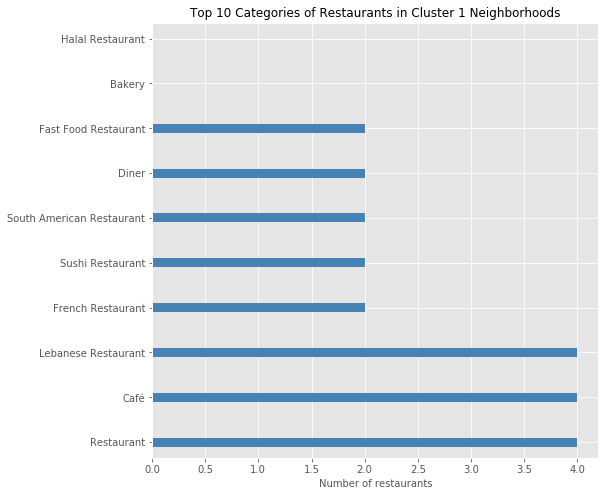

In [51]:
freq_sum_cluster1.sort_values(ascending=False, inplace=True)
freq_sum_cluster1[0:10].plot(kind='barh', figsize=(8, 8), color='steelblue', width=0.2)
plt.xlabel('Number of restaurants', fontsize=10)
plt.title('Top 10 Categories of Restaurants in Cluster 1 Neighborhoods', fontsize=12)
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
#plt.xlim(0, 50)
plt.savefig('Cluster1.png')

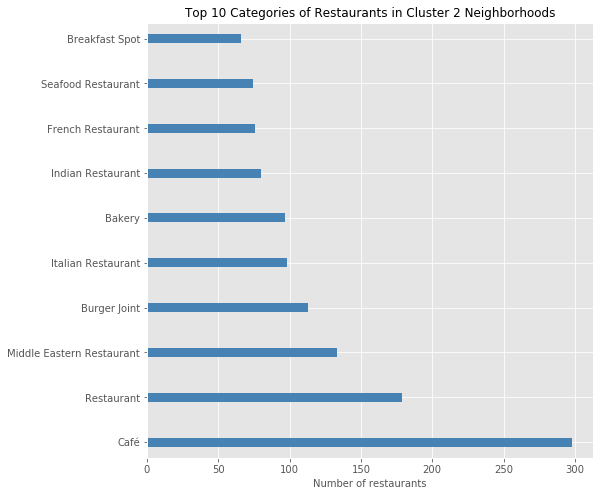

In [52]:
freq_sum_cluster2.sort_values(ascending=False, inplace=True)
freq_sum_cluster2[0:10].plot(kind='barh', figsize=(8, 8), color='steelblue', width=0.2)
plt.xlabel('Number of restaurants', fontsize=10)
plt.title('Top 10 Categories of Restaurants in Cluster 2 Neighborhoods', fontsize=12)
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
#plt.xlim(0, 50)
plt.savefig('Cluster2.png')

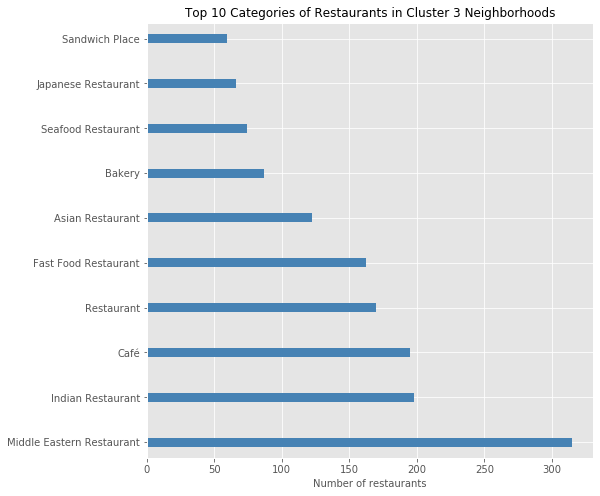

In [53]:
freq_sum_cluster3.sort_values(ascending=False, inplace=True)
freq_sum_cluster3[0:10].plot(kind='barh', figsize=(8, 8), color='steelblue', width=0.2)
plt.xlabel('Number of restaurants', fontsize=10)
plt.title('Top 10 Categories of Restaurants in Cluster 3 Neighborhoods', fontsize=12)
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
#plt.xlim(0, 50)
plt.savefig('Cluster3.png')

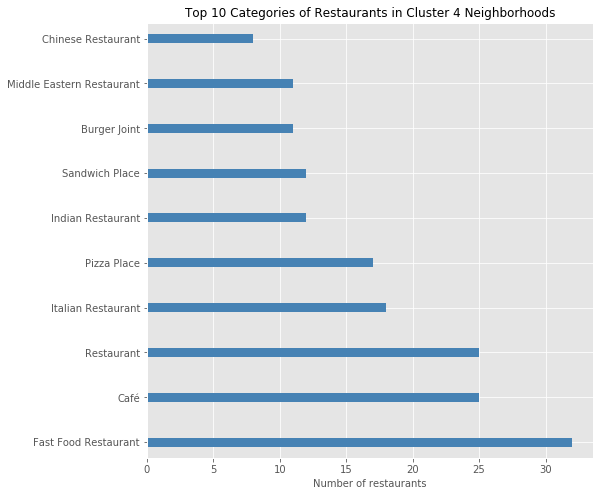

In [54]:
freq_sum_cluster4.sort_values(ascending=False, inplace=True)
freq_sum_cluster4[0:10].plot(kind='barh', figsize=(8, 8), color='steelblue', width=0.2)
plt.xlabel('Number of restaurants', fontsize=10)
plt.title('Top 10 Categories of Restaurants in Cluster 4 Neighborhoods', fontsize=12)
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
#plt.xlim(0, 50)
plt.savefig('Cluster4.png')

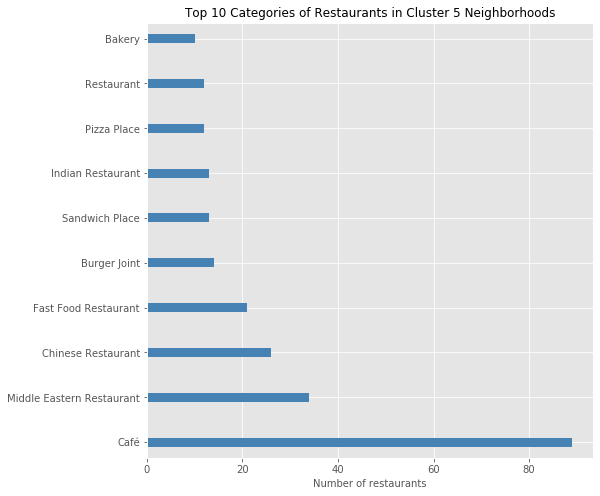

In [55]:
freq_sum_cluster5.sort_values(ascending=False, inplace=True)
freq_sum_cluster5[0:10].plot(kind='barh', figsize=(8, 8), color='steelblue', width=0.2)
plt.xlabel('Number of restaurants', fontsize=10)
plt.title('Top 10 Categories of Restaurants in Cluster 5 Neighborhoods', fontsize=12)
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
#plt.xlim(0, 50)
plt.savefig('Cluster5.png')

Assuming our client is interested in a breakfast spot, we can see that only cluster 2 has breakfast spots in the top 10 categories.
To attract a good percentage of the population, it will be a good idea to open a restaurant in the main city central Dubai, i.e. represented by
cluster 3. Let's see the top 5 most populated neighborhoods of Cluster 3.

In [64]:
freq_analysis_cluster3.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Bosnian Restaurant,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Pastelaria,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shawarma Place,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant,Total Restaurants,Total population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BARAHA, DUBAI",0,2,2,0,6,0,1,0,2,0,0,0,0,2,1,2,0,0,7,0,0,2,0,0,0,1,0,1,0,0,0,0,5,1,0,0,0,0,2,3,0,0,0,1,0,0,0,8,0,2,1,0,3,1,1,0,1,1,0,13,0,0,0,0,3,0,0,2,0,1,0,0,7,0,0,2,0,4,0,0,0,0,0,1,0,1,1,0,0,1,2,0,1,0,0,0,2,100,24747,25.281368,55.319413,2,Middle Eastern Restaurant,Indian Restaurant,Café,Restaurant,Asian Restaurant,Fast Food Restaurant,Seafood Restaurant,Japanese Restaurant,Fried Chicken Joint,North Indian Restaurant
1,"BUTEEN, DUBAI",0,2,2,0,6,0,1,0,3,0,0,0,0,2,1,0,0,0,9,0,0,2,0,0,0,2,0,1,0,0,0,0,4,1,0,0,0,0,2,3,0,0,0,0,0,0,0,8,0,2,1,0,4,2,1,0,1,0,0,10,0,0,0,0,3,0,0,2,0,1,0,0,7,0,0,2,0,3,0,1,0,0,0,1,0,1,2,0,1,1,2,0,1,1,0,0,1,100,2841,25.263057,55.320584,2,Middle Eastern Restaurant,Café,Indian Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Fast Food Restaurant,North Indian Restaurant,Seafood Restaurant,Bakery
2,"GARHOUD, DUBAI",0,2,3,0,3,0,0,0,0,0,0,0,0,1,1,1,0,2,13,0,0,2,0,0,0,0,1,1,0,0,0,0,7,0,0,0,0,0,1,2,0,0,0,0,0,0,0,2,0,1,1,0,1,0,1,0,1,1,1,16,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,4,1,4,0,2,0,0,0,2,0,2,2,0,0,1,3,0,0,0,0,0,2,93,18535,25.239696,55.358443,2,Middle Eastern Restaurant,Café,Fast Food Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,American Restaurant,Asian Restaurant,Thai Restaurant,Snack Place
3,"HAMRIYA, DUBAI",0,1,2,0,5,0,1,0,2,0,0,0,0,1,1,2,0,0,8,0,0,2,0,0,0,1,0,1,0,0,0,0,7,1,0,0,0,0,2,3,0,0,0,1,0,0,0,8,0,2,0,0,4,1,1,0,0,1,0,14,0,0,0,0,2,1,0,2,0,1,0,0,7,0,0,2,0,4,0,0,0,0,0,1,0,1,1,0,0,1,2,0,1,0,0,0,2,100,36738,25.287657,55.323997,2,Middle Eastern Restaurant,Café,Indian Restaurant,Fast Food Restaurant,Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,Fried Chicken Joint,French Restaurant
4,"KARAMA, DUBAI",0,1,2,0,5,0,1,0,2,0,0,0,0,2,0,0,0,0,10,0,0,3,0,0,0,2,0,1,0,0,0,0,3,2,0,0,0,0,4,2,1,0,0,2,0,0,0,11,1,1,1,0,4,3,1,0,1,0,0,6,0,0,0,0,2,2,0,2,0,0,0,1,6,0,0,1,0,3,0,1,0,0,0,1,1,2,1,0,1,1,1,0,1,0,0,0,1,100,75066,25.248230,55.305157,2,Indian Restaurant,Café,Middle Eastern Restaurant,Restaurant,Asian Restaura

In [68]:
sorted_cluster3=freq_analysis_cluster3.sort_values(by='Total population', ascending=False)
top5pop=sorted_cluster3.head()

In [69]:
top5pop

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Bosnian Restaurant,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kurdish Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Noodle House,North Indian Restaurant,Pakistani Restaurant,Pastelaria,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shawarma Place,Snack Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Syrian Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yemeni Restaurant,Total Restaurants,Total population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"MUHAISANAH , DUBAI",0,0,2,0,6,0,1,1,7,0,0,0,0,1,0,2,0,3,6,0,0,0,0,0,0,1,2,1,0,0,0,1,13,1,0,3,0,0,0,2,0,0,0,0,0,0,0,12,0,0,0,3,0,0,0,0,0,2,0,10,0,0,0,0,0,1,0,0,0,3,0,0,9,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,100,196316,25.280555,55.410502,2,Fast Food Restaurant,Indian Restaurant,Middle Eastern Restaurant,Restaurant,Bakery,Café,Asian Restaurant,Sandwich Place,Italian Restaurant,Pizza Place
9,"NAHDA , DUBAI",0,1,3,0,4,0,2,0,7,0,0,0,0,1,0,2,0,0,6,0,0,1,0,0,0,0,1,0,0,0,0,3,8,1,0,1,0,0,0,2,0,0,0,0,0,0,0,3,0,2,0,4,2,0,2,1,0,1,1,20,0,0,0,0,0,1,0,0,0,1,0,0,6,0,0,2,0,3,2,0,0,0,0,0,1,0,1,0,0,0,2,0,1,0,0,0,1,100,93385,25.288351,55.363138,2,Middle Eastern Restaurant,Fast Food Restaurant,Bakery,Restaurant,Café,Asian Restaurant,Italian Restaurant,American Restaurant,Falafel Restaurant,Indian Restaurant
18,"HOR AL ANZ, DUBAI",0,1,2,0,4,0,2,0,3,0,0,0,0,2,1,1,0,0,5,0,0,3,0,0,0,1,0,1,0,0,0,0,6,1,0,0,0,0,1,3,0,0,0,0,0,0,0,3,0,2,1,2,5,1,1,0,1,1,0,14,0,0,0,0,1,1,0,2,0,1,0,0,7,0,0,2,0,4,0,0,0,0,0,1,1,2,2,0,1,1,3,0,1,0,0,0,2,100,83187,25.277042,55.337300,2,Middle Eastern Restaurant,Restaurant,Fast Food Restaurant,Café,Japanese Restaurant,Asian Restaurant,Seafood Restaurant,Fried Chicken Joint,Thai Restaurant,Chinese Restaurant
4,"KARAMA, DUBAI",0,1,2,0,5,0,1,0,2,0,0,0,0,2,0,0,0,0,10,0,0,3,0,0,0,2,0,1,0,0,0,0,3,2,0,0,0,0,4,2,1,0,0,2,0,0,0,11,1,1,1,0,4,3,1,0,1,0,0,6,0,0,0,0,2,2,0,2,0,0,0,1,6,0,0,1,0,3,0,1,0,0,0,1,1,2,1,0,1,1,1,0,1,0,0,0,1,100,75066,25.248230,55.305157,2,Indian Restaurant,Café,Middle Eastern Restaurant,Restaurant,Asian Restaurant,French Restaurant,Japanese Restaurant,Korean Restaurant,Chinese Restaurant,Seafood Restaurant
10,"QUSAIS , DUBAI",1,0,2,0,4,0,1,0,6,0,1,0,0,1,0,2,1,0,5,0,0,0,0,0,0,0,1,1,0,0,0,4,9,1,0,1,0,0,0,2,0,0,0,0,0,0,0,4,0,1,0,5,0,0,1,1,0,2,0,23,0,0,0,0,0,1,0,0,0,2,0,0,6,0,0,4,0,2,1,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,100,65292,25.286564,55.386481,2,Middle Eastern Restaurant,Fast Food Restaurant,Bakery,Restaurant,Café,Italian Restaura

In [75]:
top5pop[['Neighborhood','Breakfast Spot','Total Restaurants','Total population']]

,Neighborhood,Breakfast Spot,Total Restaurants,Total population
20,"MUHAISANAH , DUBAI",1,100,196316
9,"NAHDA , DUBAI",1,100,93385
18,"HOR AL ANZ, DUBAI",2,100,83187
4,"KARAMA, DUBAI",2,100,75066
10,"QUSAIS , DUBAI",1,100,65292


As we can see there are very few breakfast spots in these neighborhoods of central Dubai although the population is higher. So as 
a starting point, we suggest to consider these neihgborhoods as they are underserved for a breakfast spot.